In [1]:
#FUNÇÃO PARA LIMPAR RESULTADOS
import numpy as np

def clear_results(valores, tol=1e-5):
    valores = np.array(valores)
    valores[np.abs(valores) < tol] = 0
    return valores

In [2]:
#BIBLIOTECAS
import numpy as np
from roboticstoolbox import ET, ERobot, Link, mstraj
from spatialmath import SE3
import sympy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Definindo os parâmetros do robô Cookbot
a2 = 0.6
a3 = 0.2
m0 = 0.816
m1 = 1.094
m2 = 1.958
m3 = 0.3
g = 9.81
I0 = np.array([[4.653, -5646.462e-06, 78206.614e-06],
                [-5646.462e-06, 4.743, 3671.124e-06],
                [78206.614e-06, 3671.124e-06, 3.209]])
I1 = np.array([[1.206, -5684.267e-07, -4.323e-02],
                [-5684.267e-07, 1.217, -17964.573e-07],
                [-4.323e-02, -17964.573e-07, 1.835e-06]])
I2 = np.array([[0.005, 4.019e-05, -0.001],
                [4.019e-05, 0.099, 5.948e-06],
                [-0.001,  5.948e-06, 0.101]])
I3 = np.array([[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]])
# Definindo o manipulador robótico
link0 = Link(ET.tz(qlim=[0, 0.170]), r = [3.222e-3, 0.155e-3, 46.056e-3], m = m0, I = I0, Tc = 0.0107, Jm = 2.4e-07, B = 2e-04)
link1 = Link(ET.tz(0.300) * ET.Rz(qlim=[-np.pi, np.pi]), r = [0.002836, 0.000116, 0.110482], m = m1, I = I1, Tc = 0.0107, Jm = 2.4e-07, B = 2e-04)
link2 = Link(ET.tx(a2) * ET.tx(a3) * ET.Rx(qlim=[-np.pi, np.pi]), r = [0.266, -6.265e-5, 0.034], m = m2, I = I2, Tc = 0.0107, Jm = 2.4e-07, B = 2e-04)
link3 = Link(ET.Ry(np.pi/6) * ET.tz(-0.100) * ET.tx(0.100) * ET.tz(0.100), r = [0.266, -6.265e-5, 0.034], m = m2, I = I2, Tc = 0.0107, Jm = 2.4e-07, B = 2e-04)

cookbot = ERobot([link0, link1, link2, link3], name="Cookbot")
print(cookbot)
print(cookbot.dynamics())

ERobot: Cookbot, 3 joints (PRR), dynamics
┌──────┬─────────┬───────┬────────┬────────────────────────────────────────┐
│ link │  link   │ joint │ parent │          ETS: parent to link           │
├──────┼─────────┼───────┼────────┼────────────────────────────────────────┤
│    0 │ link-0  │     0 │ BASE   │ tz(q0)                                 │
│    1 │ link-1  │     1 │ link-0 │ tz(0.3) ⊕ Rz(q1)                       │
│    2 │ link-2  │     2 │ link-1 │ tx(0.6) ⊕ tx(0.2) ⊕ Rx(q2)             │
│    3 │ @link-3 │       │ link-2 │ Ry(30°) ⊕ tz(-0.1) ⊕ tx(0.1) ⊕ tz(0.1) │
└──────┴─────────┴───────┴────────┴────────────────────────────────────────┘

┌────────┬────────┬──────────────────────────────┬──────────────────────────────────────────────────────┬──────────┬─────────┬──────────────────┬────┐
│   j    │   m    │              r               │                          I                           │    Jm    │    B    │        Tc        │ G  │
├────────┼────────┼────────────────────

In [4]:
# ANÁLISE SINGULARIDADES
from roboticstoolbox import jsingu
import sympy as sp

#variáveis simbólicas
q0, q1, q2 = sp.symbols('q0 q1 q2')
pos_sim = (q0, q1, q2)

#definindo a cinemática direta simbólica
TE = cookbot.fkine([q0, q1, q2])
print("A cinemática direta simbólica é:")
print(TE)

#componente translacional do end-effector
p = TE.t

#definindo as variáveis simbólicas para o jacobiano
q = pos_sim

#definindo o jacobiano simbólico
J = sp.Matrix(p).jacobian(q)
print("O Jacobiano simbólico é:")
print(J)
print(sp.Matrix.rank(J))
detJ = J.det()
print("O Determinante do Jacobiano é:", detJ)
# Valores de q1 que geram singularidades

solq1 = sp.solve(detJ, q1)
print("Valores de q1 que geram singularidades:", solq1) # disso vemos que q1 não gera singularidades!
solq2 = sp.solve(detJ, q2)
print("Valores de q2 que geram singularidades:", solq2)  


A cinemática direta simbólica é:
  -0.5*sin(q1)*sin(q2) + 0.866025403784439*cos(q1) -1.0*sin(q1)*cos(q2) 0.866025403784439*sin(q1)*sin(q2) + 0.5*cos(q1) -0.05*sin(q1)*sin(q2) + 0.886602540378444*cos(q1)  
  0.866025403784439*sin(q1) + 0.5*sin(q2)*cos(q1) 1.0*cos(q1)*cos(q2) 0.5*sin(q1) - 0.866025403784439*sin(q2)*cos(q1) 0.886602540378444*sin(q1) + 0.05*sin(q2)*cos(q1)  
  -0.5*cos(q2) 1.0*sin(q2)  0.866025403784439*cos(q2) 1.0*q0 - 0.05*cos(q2) + 0.3  
  0            0            0            1.00000000000000  

O Jacobiano simbólico é:
Matrix([[0, -0.886602540378444*sin(q1) - 0.05*sin(q2)*cos(q1), -0.05*sin(q1)*cos(q2)], [0, -0.05*sin(q1)*sin(q2) + 0.886602540378444*cos(q1), 0.05*cos(q1)*cos(q2)], [1.00000000000000, 0, 0.05*sin(q2)]])
3
O Determinante do Jacobiano é: -0.0025*sin(q1)**2*sin(q2)*cos(q2) - 0.0025*sin(q2)*cos(q1)**2*cos(q2)
Valores de q1 que geram singularidades: []
Valores de q2 que geram singularidades: [-1.57079632679490, 0.0, 1.57079632679490]


POS0: [0.88660254 0.00868241 0.25075961]
POS1: [-0.00868241  0.88660254  0.42075961]
POS2: [5.42887482e-17 8.86602540e-01 2.50000000e-01]
POS3: [-0.00868241  0.88660254  0.34075961]
POS4: [-0.88660254 -0.00868241  0.42075961]
POS5: [-0.88660254  0.04924039  0.29131759]
Vetor de posições: [[0.         0.         0.17453293]
 [0.17       1.57079633 0.17453293]
 [0.         1.57079633 0.        ]
 [0.09       1.57079633 0.17453293]
 [0.17       3.14159265 0.17453293]
 [0.         3.14159265 4.88692191]]


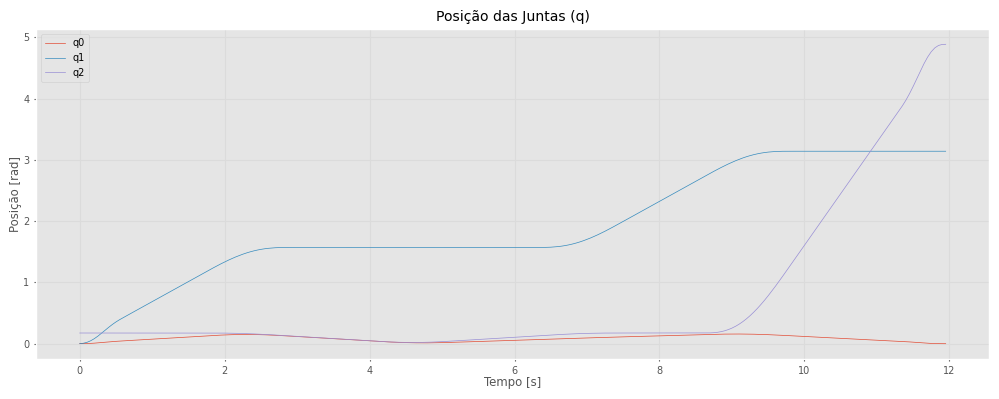

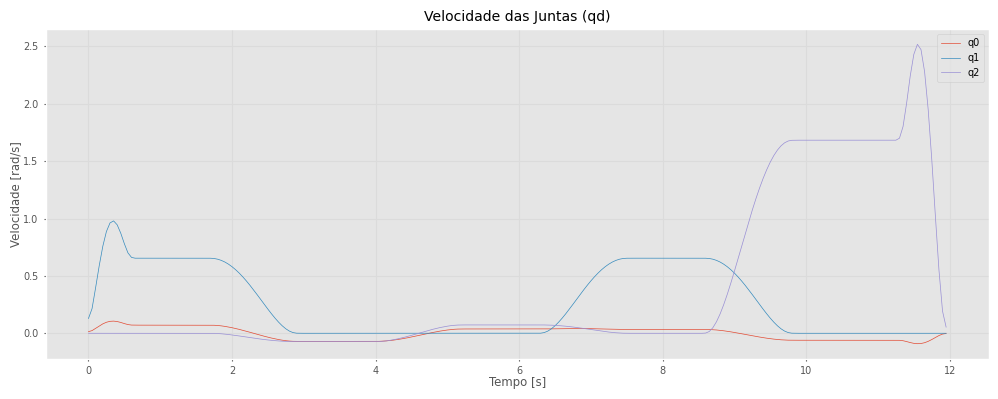

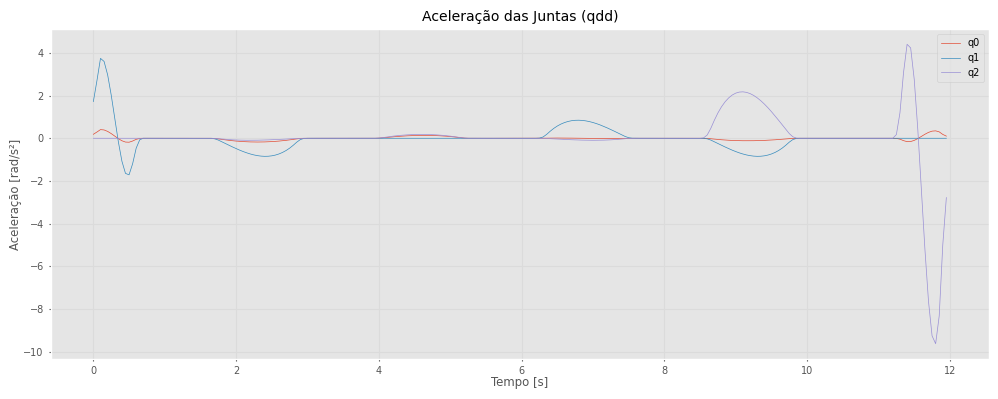

In [5]:
#TRAJETÓRIA IDEAL
#TRAJETÓRIAS
frit = 10
despfrit = 280
#batatas serão despejadas na bandeja
POS0 = cookbot.fkine([0, 0, np.deg2rad(frit)])
print("POS0:", POS0.t)
#posição 1: batatas acima da fritadeira
POS1 = cookbot.fkine([0.17, np.pi/2, np.deg2rad(frit)])
print("POS1:", POS1.t)
#posição 2: batatas  dentro da fritadeira
POS2 = cookbot.fkine([0, np.pi/2, 0])
print("POS2:", POS2.t)
#posição 3: retirar as batatas da fritadeira
POS3 = cookbot.fkine([0.09, np.pi/2, np.deg2rad(frit)])
print("POS3:", POS3.t)
#posição 4: batatas acima da bandeja de despejo
POS4 = cookbot.fkine([0.17, np.pi, np.deg2rad(frit)])
print("POS4:", POS4.t)
#posição 5: despejar as batatas na bandeja
POS5 = cookbot.fkine([0, np.pi, np.deg2rad(despfrit)])
print("POS5:", POS5.t)

#Crinado um vetor com as posições
viapoints = np.array([
    [0, 0, np.deg2rad(frit)],                       # POS0
    [0.17, np.pi/2, np.deg2rad(frit)],              # POS1
    [0, np.pi/2, 0],                                # POS2
    [0.09, np.pi/2, np.deg2rad(frit)],              # POS3
    [0.17, np.pi, np.deg2rad(frit)],                # POS4
    [0, np.pi, np.deg2rad(despfrit)],               # POS5
])
print("Vetor de posições:", viapoints)
#vetor com os tempos de cada segmento

traj_final = mstraj(
    viapoints=viapoints, 
    dt=0.05, 
    tacc=1.2, 
    qdmax = 3
)

#VELOCIDADE E ACELERAÇÃO DAS JUNTAS

t = traj_final.t  # Tempo da trajetória
q = traj_final.q  # Posições das juntas

# Derivada numérica para obter velocidade
qd = np.gradient(q, t, axis=0)

# Derivada numérica para obter aceleração
qdd = np.gradient(qd, t, axis=0)

# PLOT DOS GRÁFICOS

# Plot das posições (q)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, q[:, i], label=f'q{i}')
plt.title('Posição das Juntas (q)')
plt.xlabel('Tempo [s]')
plt.ylabel('Posição [rad]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot das velocidades (qd)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, qd[:, i], label=f'q{i}')
plt.title('Velocidade das Juntas (qd)')
plt.xlabel('Tempo [s]')
plt.ylabel('Velocidade [rad/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot das acelerações (qdd)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, qdd[:, i], label=f'q{i}')
plt.title('Aceleração das Juntas (qdd)')
plt.xlabel('Tempo [s]')
plt.ylabel('Aceleração [rad/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



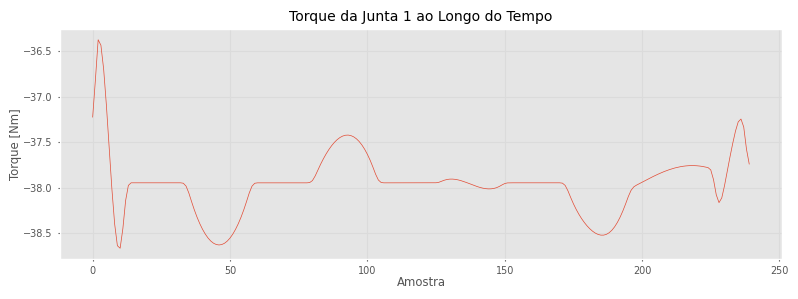

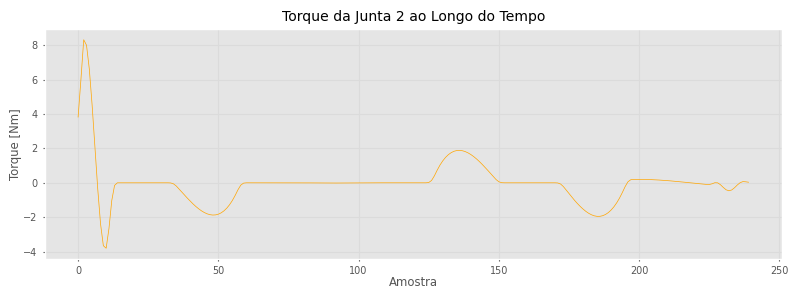

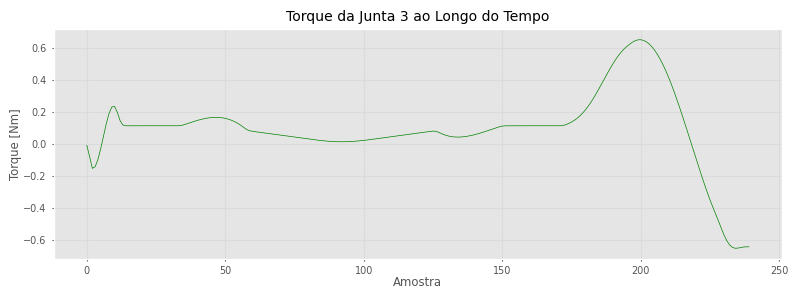

In [6]:
#PLOTS DE TORQUE IDEAL

# Cálculo do torque ideal usando a função rne (Robotic Newton-Euler)
Qtraj = cookbot.rne(q, qd, qdd, gravity=[0, 0, g], symbolic=False)

t = np.arange(Qtraj.shape[0])  # vetor de tempo (amostras)

# Junta 1    
plt.figure(figsize=(8, 3))
plt.plot(t, Qtraj[:, 0], label='Torque Junta 1')
plt.xlabel('Amostra')
plt.ylabel('Torque [Nm]')
plt.title('Torque da Junta 1 ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

# Junta 2
plt.figure(figsize=(8, 3))
plt.plot(t, Qtraj[:, 1], label='Torque Junta 2', color='orange')
plt.xlabel('Amostra')
plt.ylabel('Torque [Nm]')
plt.title('Torque da Junta 2 ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

# Junta 3
plt.figure(figsize=(8, 3))
plt.plot(t, Qtraj[:, 2], label='Torque Junta 3', color='green')
plt.xlabel('Amostra')
plt.ylabel('Torque [Nm]')
plt.title('Torque da Junta 3 ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


In [ ]:
# VELOCIDADE E ACELERAÇÃO DAS JUNTAS
t = traj_final.t  # Tempo da trajetória
q_des = traj_final.q  # Posições das juntas
qd_des = np.gradient(q_des, t, axis=0)   # Velocidade
qdd_des = np.gradient(qd_des, t, axis=0) # Aceleração

# Função de torque para passar ao fdyn
def torque(cookbot, t_atual, q, qd):
    # Encontrar o índice de tempo mais próximo
    idx = np.argmin(np.abs(t - t_atual))
    q_ref = q_des[idx]
    qd_ref = qd_des[idx]
    Kp = 50.0
    Kd = 20.2
    error = q_ref - q
    error_dot = qd_ref - qd
    grav = cookbot.gravload(q)
    tau = Kp * error + Kd * error_dot + grav
    return tau

# Condições iniciais
q0 = q_des[0]
qd0 = qd_des[0]

print(q_des.shape)    # O segundo valor (q_des.shape[1]) deve ser igual a cookbot.n
print(q0)             # Deve ter cookbot.n elementos

# Simule a dinâmica do robô sob esse torque
out = cookbot.fdyn(
    T=2,
    q0=q0,
    Q=torque,
    qd0=qd0,
    dt = 0.5,
    progress = True
)

# Trajetória real do robô
q_real = out.q   # posições reais das juntas
qd_real = out.qd # velocidades reais das juntas

# (Opcional) Plot para comparação de trajetória desejada x real:
plt.figure()
plt.plot(t, q_des[:, 0], '--', label='Desejada - Junta 1')
plt.plot(out.t, q_real[:, 0], '-', label='Real - Junta 1')
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (rad)')
plt.legend()
plt.title('Junta 1 - Trajetória Desejada vs Real')
plt.show()


(240, 3)
[1.13215282e-04 1.04610676e-03 1.74532925e-01]
